In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.max_columns", None)

In [7]:
# Reading in datasets
col_names = pd.read_csv('datasets/features_edited.txt', header = None)
features = col_names[0].str.strip().to_list()
datasets_filepath = ['Train/X_train',
                     'Train/y_train',
                     'Test/X_test',
                     'Test/y_test']
df = []
for filepath in datasets_filepath:
    df.append(pd.read_csv('datasets/' + filepath + '.txt', sep = ' ', header = None))
x_train, y_train, x_test, y_test = df[0], df[1], df[2], df[3]
x_train.columns, x_test.columns = features, features
y_train.columns, y_test.columns = ['Activity',], ['Activity',]
activity_labels_dict = {1: 'WALKING', 2: 'WALKING_UPSTAIRS', 3: 'WALKING_DOWNSTAIRS', 4: 'SITTING', 5: 'STANDING', 6: 'LAYING',
                7: 'STAND_TO_SIT', 8: 'SIT_TO_STAND', 9: 'SIT_TO_LIE', 10: 'LIE_TO_SIT', 11: 'STAND_TO_LIE', 12: 'LIE_TO_STAND'}

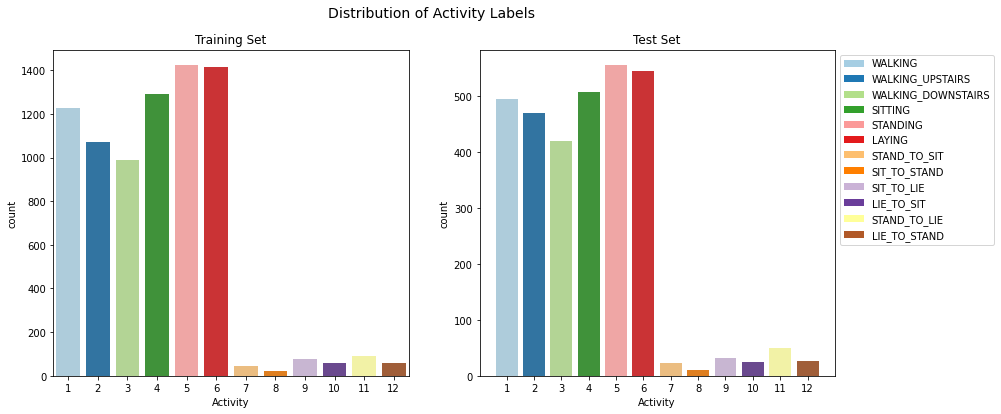

In [8]:
activity_labels = [activity_labels_dict[i] for i in range(1,13)]
custom_palette = sns.color_palette("Paired", 13)
fig, ax = plt.subplots(1, 2, figsize = (14,6))
fig.suptitle('Distribution of Activity Labels', size = 14)
sns.countplot(data = y_train, x = 'Activity', palette = custom_palette, ax = ax[0])
sns.countplot(data = y_test, x = 'Activity', palette = custom_palette, ax = ax[1])
ax[0].set_title('Training Set')
ax[1].set_title('Test Set')
for feature, color in zip(activity_labels, custom_palette):
    ax[1].bar(0.5, 0.5, color = color, label = feature)
plt.legend(loc = 2, bbox_to_anchor = (1,1))

Data clearly imbalanced. Resampling required.

In [90]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

In [10]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
strategy = {7: 700, 8: 700, 9: 700, 10: 700, 11: 700, 12: 700}

In [11]:
# Oversampling
oversample = RandomOverSampler(sampling_strategy = strategy)
x_over, y_over = oversample.fit_resample(x_train, y_train)

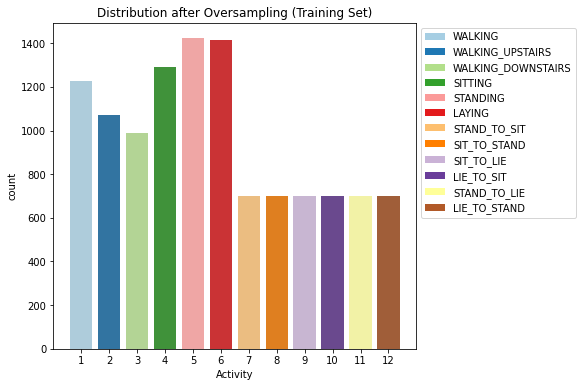

In [12]:
activity_labels = [activity_labels_dict[i] for i in range(1,13)]
custom_palette = sns.color_palette("Paired", 13)
fig, ax = plt.subplots(figsize = (6.5,6))
sns.countplot(data = y_over, x = 'Activity', palette = custom_palette)
ax.set_title('Distribution after Oversampling (Training Set)')
for feature, color in zip(activity_labels, custom_palette):
    ax.bar(0.5, 0.5, color = color, label = feature)
plt.legend(loc = 2, bbox_to_anchor = (1,1))

In [13]:
rf_over = RandomForestClassifier(random_state = 0)
rf_over.fit(x_over, y_over.values.ravel())

RandomForestClassifier(random_state=0)

In [92]:
cv = StratifiedKFold(n_splits = 10, random_state = 0, shuffle = True)
scores = cross_val_score(rf_over, x_over, y_over, scoring = 'accuracy', cv = cv, n_jobs = -1)
print('%.2f (%.2f)' % (np.mean(scores), np.std(scores)))

0.99 (0.00)


In [14]:
y_pred_over = rf_over.predict(x_test)
print('Accuracy: {:.2f}%'.format(accuracy_score(y_pred_over, y_test) * 100))
print('Cohen\'s kappa: {:.2f}%'.format(cohen_kappa_score(y_pred_over, y_test) * 100))
print('f1 score macro: {:.2f}%'.format(f1_score(y_pred_over, y_test, average = 'macro') * 100))
print('f1 score micro: {:.2f}%'.format(f1_score(y_pred_over, y_test, average = 'micro') * 100))

Accuracy: 91.11%
Cohen's kappa: 89.52%
f1 score macro: 81.79%
f1 score micro: 91.11%


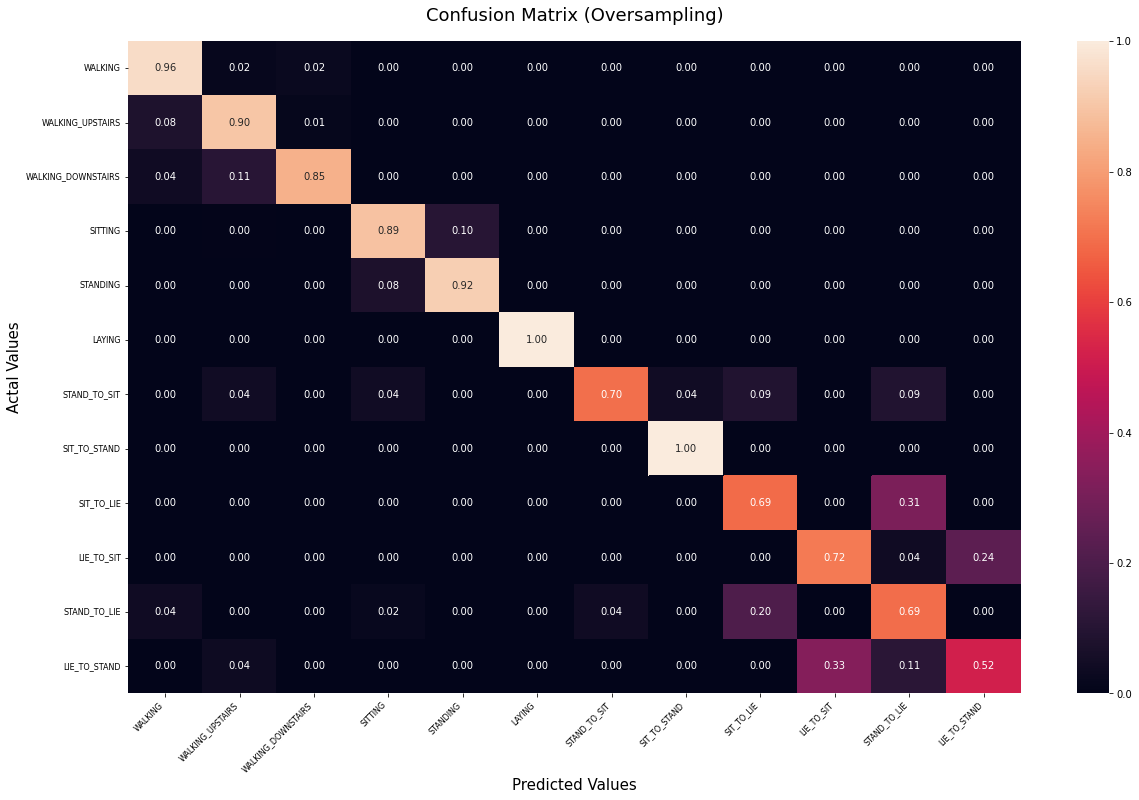

In [15]:
cm_over = confusion_matrix(y_test, y_pred_over)
cm1 = cm_over.astype('float') / cm_over.sum(axis = 1)[:, np.newaxis]
fig, ax = plt.subplots(figsize = (20,12))
sns.heatmap(cm1, annot = True, fmt = '.2f', xticklabels = activity_labels, yticklabels = activity_labels)
plt.xticks(rotation = 45, ha = 'right', size = 8)
plt.yticks(size = 8)
plt.title('Confusion Matrix (Oversampling)', size = 18, pad = 20)
plt.ylabel('Actal Values', size  = 15)
plt.xlabel('Predicted Values', size  = 15)
plt.show(block=False)

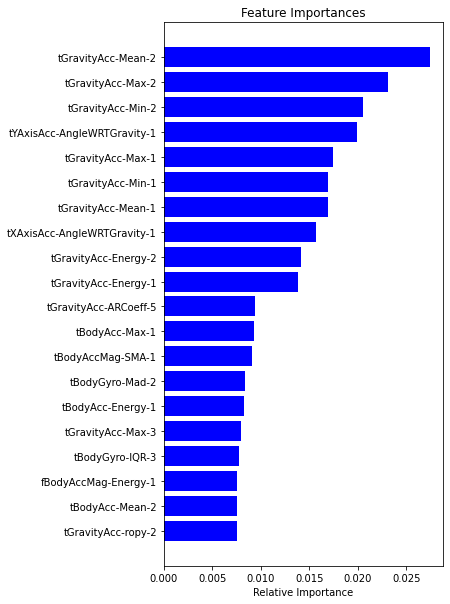

In [17]:
importances_over = rf_over.feature_importances_
indices_over = np.argsort(importances_over)

num_features = 20

plt.figure(figsize = (5,10))
plt.title('Feature Importances')

# only plot the customized number of features
plt.barh(range(num_features), importances_over[indices_over[-num_features:]], color = 'b', align = 'center')
plt.yticks(range(num_features), [features[i] for i in indices_over[-num_features:]])
plt.xlabel('Relative Importance')
plt.show()

SMOTE proposes several variants by identifying specific samples to consider during the resampling. The borderline version (BorderlineSMOTE) will detect which point to select which are in the border between two classes. The SVM version (SVMSMOTE) will use the support vectors found using an SVM algorithm to create new sample while the KMeans version (KMeansSMOTE) will make a clustering before to generate samples in each cluster independently depending each cluster density.

In [18]:
# SMOTE
oversample = RandomOverSampler(sampling_strategy = strategy)
x_smote, y_smote = oversample.fit_resample(x_train, y_train)

In [19]:
rf_smote = RandomForestClassifier(random_state = 0)
rf_smote.fit(x_smote, y_smote.values.ravel())

RandomForestClassifier(random_state=0)

In [20]:
y_pred_smote = rf_smote.predict(x_test)
print('Accuracy: {:.2f}%'.format(accuracy_score(y_pred_smote, y_test) * 100))
print('Cohen\'s kappa: {:.2f}%'.format(cohen_kappa_score(y_pred_smote, y_test) * 100))
print('f1 score macro: {:.2f}%'.format(f1_score(y_pred_smote, y_test, average = 'macro') * 100))
print('f1 score micro: {:.2f}%'.format(f1_score(y_pred_smote, y_test, average = 'micro') * 100))

Accuracy: 91.65%
Cohen's kappa: 90.16%
f1 score macro: 83.37%
f1 score micro: 91.65%


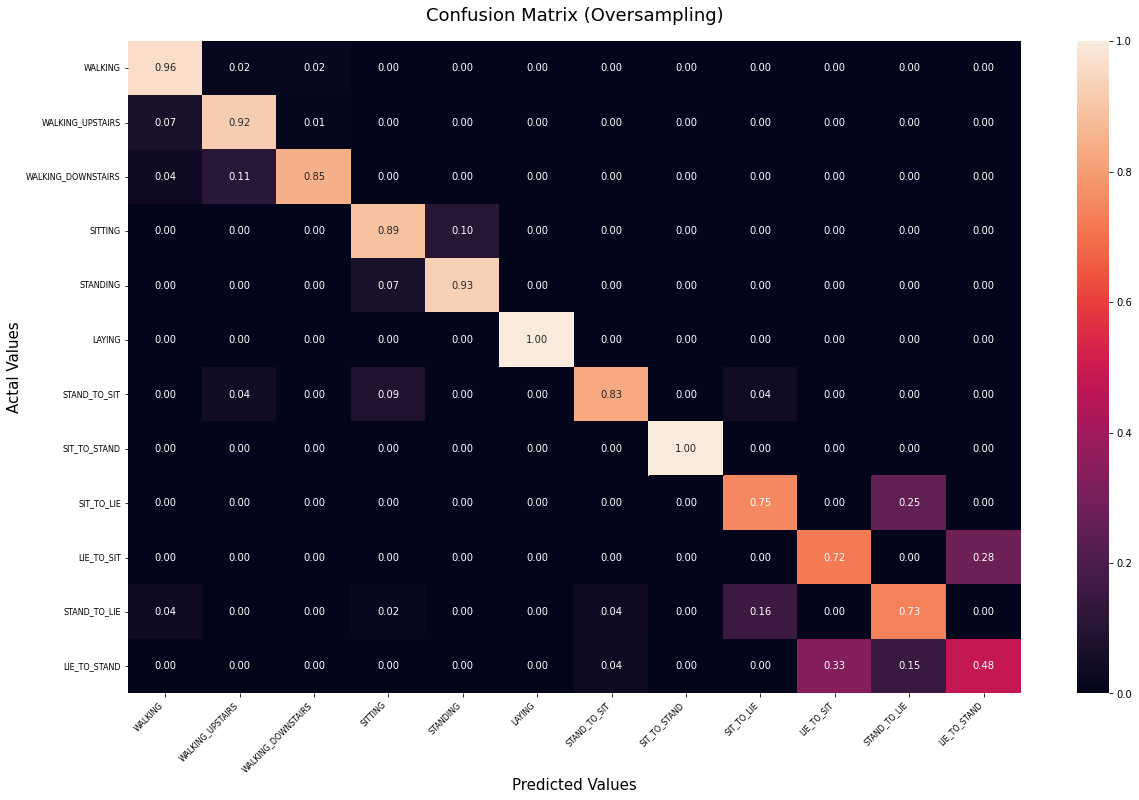

In [21]:
cm_smote = confusion_matrix(y_test, y_pred_smote)
cm2 = cm_smote.astype('float') / cm_smote.sum(axis = 1)[:, np.newaxis]
fig, ax = plt.subplots(figsize = (20,12))
sns.heatmap(cm2, annot = True, fmt = '.2f', xticklabels = activity_labels, yticklabels = activity_labels)
plt.xticks(rotation = 45, ha = 'right', size = 8)
plt.yticks(size = 8)
plt.title('Confusion Matrix (Oversampling)', size = 18, pad = 20)
plt.ylabel('Actal Values', size  = 15)
plt.xlabel('Predicted Values', size  = 15)
plt.show(block=False)

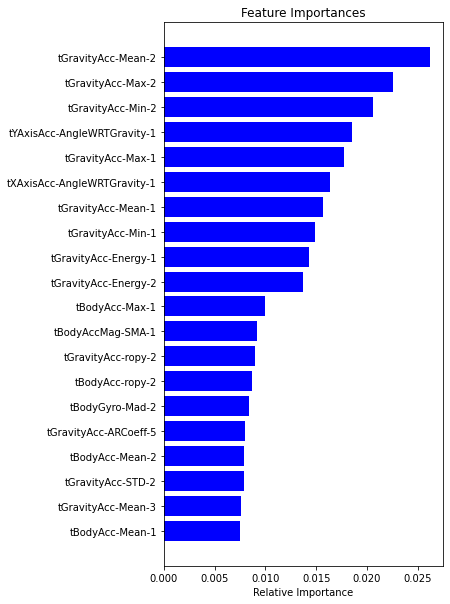

In [22]:
importances_smote = rf_smote.feature_importances_
indices_smote = np.argsort(importances_smote)

num_features = 20

plt.figure(figsize = (5,10))
plt.title('Feature Importances')

# only plot the customized number of features
plt.barh(range(num_features), importances_smote[indices_smote[-num_features:]], color = 'b', align = 'center')
plt.yticks(range(num_features), [features[i] for i in indices_smote[-num_features:]])
plt.xlabel('Relative Importance')
plt.show()

Investigated various SMOTE resampling methods, produced similar results.

Top 10 features for both models are the same just ordered differently.

In [23]:
print([features[i] for i in indices_over[-10:]])
print([features[i] for i in indices_smote[-10:]])

['tGravityAcc-Energy-1', 'tGravityAcc-Energy-2', 'tXAxisAcc-AngleWRTGravity-1', 'tGravityAcc-Mean-1', 'tGravityAcc-Min-1', 'tGravityAcc-Max-1', 'tYAxisAcc-AngleWRTGravity-1', 'tGravityAcc-Min-2', 'tGravityAcc-Max-2', 'tGravityAcc-Mean-2']
['tGravityAcc-Energy-2', 'tGravityAcc-Energy-1', 'tGravityAcc-Min-1', 'tGravityAcc-Mean-1', 'tXAxisAcc-AngleWRTGravity-1', 'tGravityAcc-Max-1', 'tYAxisAcc-AngleWRTGravity-1', 'tGravityAcc-Min-2', 'tGravityAcc-Max-2', 'tGravityAcc-Mean-2']


Tree-based estimators can be used to compute impurity-based feature importances, which in turn can be used to discard irrelevant features (when coupled with the SelectFromModel meta-transformer).

In [37]:
from sklearn.feature_selection import SelectFromModel

In [38]:
clf = RandomForestClassifier(random_state = 0)
clf.fit(x_smote, y_smote.values.ravel())

RandomForestClassifier(random_state=0)

In [56]:
model = SelectFromModel(clf, prefit = True)
x_new = model.transform(x_smote)
new_features = np.array(features)[model.get_support()]

In [59]:
clf.fit(x_new, y_smote.values.ravel())

RandomForestClassifier(random_state=0)

In [62]:
x_test_new = x_test[new_features]
y_pred = clf.predict(x_test_new)
print('Accuracy: {:.2f}%'.format(accuracy_score(y_pred, y_test) * 100))
print('Cohen\'s kappa: {:.2f}%'.format(cohen_kappa_score(y_pred, y_test) * 100))
print('f1 score macro: {:.2f}%'.format(f1_score(y_pred, y_test, average = 'macro') * 100))
print('f1 score micro: {:.2f}%'.format(f1_score(y_pred, y_test, average = 'micro') * 100))

Accuracy: 90.61%
Cohen's kappa: 88.92%
f1 score macro: 82.67%
f1 score micro: 90.61%


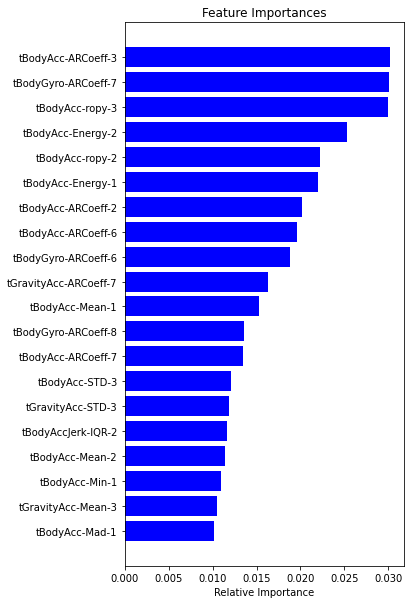

In [63]:
importances = clf.feature_importances_
indices = np.argsort(importances)

num_features = 20

plt.figure(figsize = (5,10))
plt.title('Feature Importances')

# only plot the customized number of features
plt.barh(range(num_features), importances[indices[-num_features:]], color = 'b', align = 'center')
plt.yticks(range(num_features), [features[i] for i in indices[-num_features:]])
plt.xlabel('Relative Importance')
plt.show()

Impurity-based feature importance for trees are strongly biased and favor high cardinality features (typically numerical features) over low cardinality features such as binary features or categorical variables with a small number of possible categories.

In [70]:
from sklearn.inspection import permutation_importance

from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

In [67]:
clf2 = RandomForestClassifier(random_state = 0)
clf2.fit(x_smote, y_smote.values.ravel())

RandomForestClassifier(random_state=0)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(x_train).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T)/2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels = features, ax = ax1, leaf_rotation = 90
)
dendro_idx = np.arange(0, len(dendro['ivl']))

In [73]:
from collections import defaultdict

In [76]:
cluster_ids = hierarchy.fcluster(dist_linkage, 1, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

In [86]:
x_train_sel = x_smote.iloc[:, selected_features]
x_test_sel = x_test.iloc[:, selected_features]
clf_sel = RandomForestClassifier(random_state = 0)
clf_sel.fit(x_train_sel, y_smote.values.ravel())

RandomForestClassifier(random_state=0)

In [87]:
y_pred2 = clf_sel.predict(x_test_sel)
print('Accuracy: {:.2f}%'.format(accuracy_score(y_pred2, y_test) * 100))
print('Cohen\'s kappa: {:.2f}%'.format(cohen_kappa_score(y_pred2, y_test) * 100))
print('f1 score macro: {:.2f}%'.format(f1_score(y_pred2, y_test, average = 'macro') * 100))
print('f1 score micro: {:.2f}%'.format(f1_score(y_pred2, y_test, average = 'micro') * 100))

Accuracy: 88.43%
Cohen's kappa: 86.35%
f1 score macro: 83.22%
f1 score micro: 88.43%


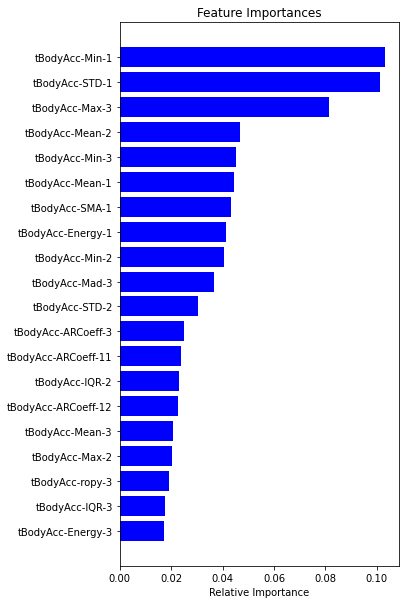

In [88]:
importances = clf_sel.feature_importances_
indices = np.argsort(importances)

num_features = 20

plt.figure(figsize = (5,10))
plt.title('Feature Importances')

# only plot the customized number of features
plt.barh(range(num_features), importances[indices[-num_features:]], color = 'b', align = 'center')
plt.yticks(range(num_features), [features[i] for i in indices[-num_features:]])
plt.xlabel('Relative Importance')
plt.show()